In [1]:
import networkx as nx
from networkx.utils import py_random_state
from networkx.generators.random_graphs import _random_subset
from networkx.generators.classic import star_graph
import scipy.stats as stats

from scipy.optimize import curve_fit
import numpy as np

import matplotlib.pyplot as plt

In [2]:
@py_random_state(2)
def barabasi_albert(n, m, seed=None, initial_graph=None):
    """Returns a random graph using Barabási–Albert preferential attachment

    A graph of $n$ nodes is grown by attaching new nodes each with $m$
    edges that are preferentially attached to existing nodes with high degree.

    Parameters
    ----------
    n : int
        Number of nodes
    m : int
        Number of edges to attach from a new node to existing nodes
    seed : integer, random_state, or None (default)
        Indicator of random number generation state.
        See :ref:`Randomness<randomness>`.
    initial_graph : Graph or None (default)
        Initial network for Barabási–Albert algorithm.
        It should be a connected graph for most use cases.
        A copy of `initial_graph` is used.
        If None, starts from a star graph on (m+1) nodes.

    Returns
    -------
    G : Graph

    Raises
    ------
    NetworkXError
        If `m` does not satisfy ``1 <= m < n``, or
        the initial graph number of nodes m0 does not satisfy ``m <= m0 <= n``.

    References
    ----------
    .. [1] A. L. Barabási and R. Albert "Emergence of scaling in
       random networks", Science 286, pp 509-512, 1999.
    """

    if m < 1 or m >= n:
        raise nx.NetworkXError(
            f"Barabási–Albert network must have m >= 1 and m < n, m = {m}, n = {n}"
        )

    if initial_graph is None:
        # Default initial graph : star graph on (m + 1) nodes
        G = star_graph(m)
    else:
        if len(initial_graph) < m or len(initial_graph) > n:
            raise nx.NetworkXError(
                f"Barabási–Albert initial graph needs between m={m} and n={n} nodes"
            )
        G = initial_graph.copy()

    # List of existing nodes, with nodes repeated once for each adjacent edge
    repeated_nodes = [n for n, d in G.degree() for _ in range(d)]
    # Start adding the other n - m0 nodes.
    source = len(G)
    while source < n:
        # Now choose m unique nodes from the existing nodes
        # Pick uniformly from repeated_nodes (preferential attachment)
        targets = _random_subset(repeated_nodes, m, seed)
        # Add edges to m nodes from the source.
        G.add_edges_from(zip([source] * m, targets))
        # Add one node to the list for each new edge just created.
        repeated_nodes.extend(targets)
        # And the new node "source" has m edges to add to the list.
        repeated_nodes.extend([source] * m)

        source += 1
    return G

## Tasso di crescita

Scale-free

In [3]:
N = int(5e4)
M = 4

N0 = 20
# BA = barabasi_albert_analysis(n,m, t=t, k_i=k_i, p_k = p_k)

In [4]:
nodes = [20, 120, 520, 1220]

In [5]:
BA = barabasi_albert(N0, M)
k_i=[[]]
I = []
for x in range(N0):
    if x in nodes:
        I += [x]
        k_i += [[]]
        
for t in range(20, N):
    BA = barabasi_albert(t+1, M, initial_graph = BA)
    if t in nodes:
        I += [t]
        k_i += [[]]
        
    iter = 0
    for i in I:
        k_i[iter] += [[t, BA.degree[i]]]
        iter += 1

 - Fit function for node 20 is 3.910711860062403*(t/t_i)^0.4211067167424794
 - Fit function for node 120 is 1.957490184292367*(t/t_i)^0.5899434833364932
 - Fit function for node 520 is 3.8161312290199794*(t/t_i)^0.391295250074315
 - Fit function for node 1220 is 4.441908005784967*(t/t_i)^0.3522586182753699


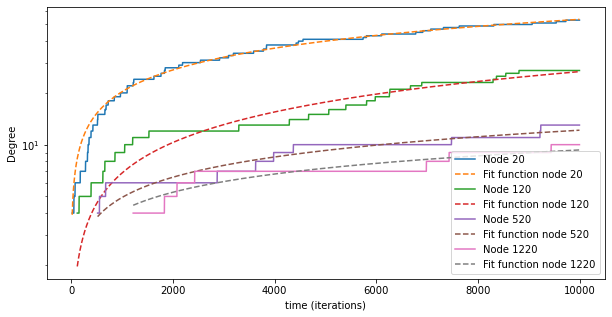

In [6]:
def degree_growth_rate(x, m, a):
    return m*np.power(x, a)

popt = [0]*len(nodes)
pcov = [0]*len(nodes)

fig, ax = plt.subplots(figsize = (10, 5))

for i in range(len(nodes)):
    x = [time for time, k in k_i[i]]
    y = [k for time, k in k_i[i]]
    
    plt.plot(x, y, '-', label = f"Node {nodes[i]}")
    
    popt[i], pcov[i] = curve_fit(degree_growth_rate, [xi/x[0] for xi in x], y)
    plt.plot(x, degree_growth_rate([xi/x[0] for xi in x], *popt[i]), '--', label = f"Fit function node {nodes[i]}")
    print(f" - Fit function for node {nodes[i]} is {popt[i][0]}*(t/t_i)^{popt[i][1]}")
#     print(stats.chisquare(y, degree_growth_rate(x, *popt[i])))

ax.set_xlabel("time (iterations)")
ax.set_ylabel("Degree")
ax.legend()

# plt.xscale('log')
plt.yscale('log')

plt.show()

## Distribuzione dei gradi

## Average path lenght

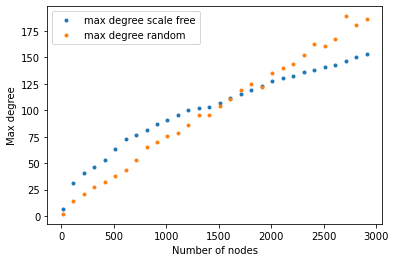

In [14]:
N = [10+i*100 for i in range(30)]
M = 3
P = 0.05

mean_path_scalefree = []
mean_path_random = []
max_degree_random = []
max_degree_scale_free = []
#diameter_scalefree = []
#diameter_random = []

Gb = star_graph(M)

for i in range(len(N)):
    Ge = nx.erdos_renyi_graph(N[i], P)
    while min([d for n, d in Ge.degree()]) == 0:
          Ge = nx.erdos_renyi_graph(N[i], P)
    Gb = nx.barabasi_albert_graph(N[i], M, initial_graph = Gb)

#     mean_path_scalefree += [nx.average_shortest_path_length(Gb)]  
#     mean_path_random += [nx.average_shortest_path_length(Ge)] 
    
    max_degree_random += [max([d for n,d in Ge.degree])]
    max_degree_scale_free += [max([d for n,d in Gb.degree])]
    
#     diameter_scalefree += [nx.diameter(Gb)]
#     diameter_random += [nx.diameter(Ge)]

fig, ax = plt.subplots()

# ax.plot(N, mean_path_scalefree, '.', label = 'scale_free_path')
# ax.plot(N, mean_path_random, '.', label = 'random_path')

ax.plot(N, max_degree_scale_free, '.', label = 'max degree scale free')
ax.plot(N, max_degree_random, '.', label = 'max degree random')

# ax.plot(N, diameter_random, '.', label = 'random_diameter')
# ax.plot(N, diameter_scalefree, '.', label = 'scale_free_diameter')

ax.set_xlabel("Number of nodes")
ax.set_ylabel("Max degree") 
ax.legend()

plt.show()

Scale free fit parameters: [2.81975814] ∓ [0.00853942]
Random fit parameters: [15.13923759] ∓ [1.0812871]
Second random fit parameters: [0.06272303 8.35771598]


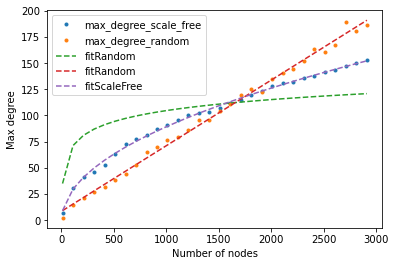

In [15]:
def sqrt_law(x, a):
    return a*np.sqrt(x)

def log_law(x, a):
    return a*np.log(x)

poptSF, pcovSF = curve_fit(sqrt_law, N, max_degree_scale_free)
poptR, pcovR = curve_fit(log_law, N, max_degree_random)
random_fit = np.polyfit(N, max_degree_random, 1)

perrSF = np.sqrt(np.diag(pcovSF))
perrR = np.sqrt(np.diag(pcovR))

print("Scale free fit parameters:", poptSF, "∓", perrSF)
print("Random fit parameters:", poptR, "∓", perrR)
print("Second random fit parameters:", random_fit)

fitRandom2 = [random_fit[0]*n + random_fit[1] for n in N]
fitScale = sqrt_law(N, *poptSF)
fitRandom = log_law(N, *poptR)

fig, ax = plt.subplots()
    
ax.plot(N, max_degree_scale_free, '.', label = 'max_degree_scale_free')
ax.plot(N, max_degree_random, '.', label = 'max_degree_random')

ax.plot(N, fitRandom, '--', label = 'fitRandom')
ax.plot(N, fitRandom2, '--', label = 'fitRandom')
ax.plot(N, fitScale, '--', label = 'fitScaleFree')

ax.set_xlabel("Number of nodes")
ax.set_ylabel("Max degree") 
ax.legend()

plt.show()